In [29]:
# Step 1️⃣: Import Libraries
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array

In [30]:
# Step 2️⃣: Load BDD100K Detection Dataset
dataset = load_dataset("dgural/bdd100k", split="train", streaming=True)


Resolving data files:   0%|          | 0/20003 [00:00<?, ?it/s]

In [41]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

IMG_SIZE = 224  # MobileNetV2 input size

def get_synthetic_label(sample):
    """
    Estimate congestion using number of vehicles in the scene:
    - <=2 vehicles → Low
    - 3-6 vehicles → Medium
    - >6 vehicles → High
    """
    objects = sample.get('objects', [])
    num_vehicles = len([obj for obj in objects if obj['category'] in ['car','truck','bus']])
    
    if num_vehicles <= 2:
        return 0  # Low
    elif num_vehicles <= 6:
        return 1  # Medium
    else:
        return 2  # High

def preprocess_sample(sample, img_size=IMG_SIZE):
    # Convert image to array
    image = sample['image'].convert('RGB').resize((img_size, img_size))
    img_array = img_to_array(image)
    img_array = preprocess_input(img_array)
    
    # Get label
    label = get_synthetic_label(sample)
    
    return img_array, label


✅ Dataset shape: (500, 224, 224, 3)
✅ Class distribution: {0: np.int64(500), 1: np.int64(0), 2: np.int64(0)}


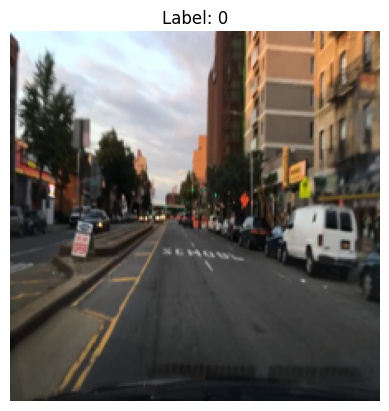

In [43]:
# Step 4️⃣: Collect Small Batch
NNUM_SAMPLES = 500  # demo limit
X, y = [], []

for i, sample in enumerate(dataset):
    img, label = preprocess_sample(sample)
    X.append(img)
    y.append(label)
    if i >= NUM_SAMPLES-1:
        break

X = np.array(X)
y = np.array(y)

print("✅ Dataset shape:", X.shape)
print("✅ Class distribution:", {0:(y==0).sum(), 1:(y==1).sum(), 2:(y==2).sum()})

# Preview a sample
plt.imshow((X[0]+1)/2)  # preprocess_input scales [-1,1], so convert to [0,1]
plt.title(f"Label: {y[0]}")
plt.axis('off')
plt.show()

In [39]:
#Step 5️⃣: Split Train & Validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

In [36]:
# Step 6️⃣: Build MobileNetV2 Model
num_classes = 3

base_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                         include_top=False, weights='imagenet')
base_model.trainable = False  # freeze pretrained layers

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,339 (9.24 MB)

 Trainable params: 164,355 (642.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [37]:
# Step 7️⃣: Train Model
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=5,
                    batch_size=16)

Epoch 1/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 252ms/step - accuracy: 0.7111 - loss: 0.6671 - val_accuracy: 0.7800 - val_loss: 0.4086
Epoch 2/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 190ms/step - accuracy: 0.7956 - loss: 0.4341 - val_accuracy: 0.8200 - val_loss: 0.4144
Epoch 3/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 210ms/step - accuracy: 0.8378 - loss: 0.3671 - val_accuracy: 0.8000 - val_loss: 0.3488
Epoch 4/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 205ms/step - accuracy: 0.8778 - loss: 0.2909 - val_accuracy: 0.8200 - val_loss: 0.3908
Epoch 5/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 11s 219ms/step - accuracy: 0.8978 - loss: 0.2530 - val_accuracy: 0.7600 - val_loss: 0.3902


In [34]:
#Step 8️⃣: Save Model
model.save("traffic_cnn_mobilenetv2.h5")
print("✅ Model saved as traffic_cnn_mobilenetv2.h5")

✅ Model saved as traffic_cnn_mobilenetv2.h5


In [38]:
# Step 9️⃣: Prediction Function
CLASS_NAMES = ["Low", "Medium", "High"]

def predict_congestion(image, model, target_size=(IMG_SIZE, IMG_SIZE)):
    image_resized = image.convert("RGB").resize(target_size)
    img_array = img_to_array(image_resized)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    
    preds = model.predict(img_array)
    pred_class = np.argmax(preds, axis=1)[0]
    confidence = float(np.max(preds))
    
    return CLASS_NAMES[pred_class], confidence


In [35]:
# Step 🔟: Test Prediction

sample_img = Image.fromarray(((X_val[0]+1)/2*255).astype(np.uint8))  # convert back to [0,255]
cls, conf = predict_congestion(sample_img, model)
print(f"Predicted: {cls} ({conf*100:.2f}%)")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
Predicted: High (100.00%)
